In [ ]:
# INITIALIZATION

# Load libraries
import os
import sys
from pathlib import Path
from datetime import datetime as dt
import rasterio as rio
import folium as fol
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# Add the src folder to the Python path
src_path = Path().resolve().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))

# Load "bioinvasionanalysis" modules
import widget_definitions as w
from thinning import thin
from leastcostpaths import paths
from populations import group_paths, group_points, upper_outlier_fence
from expansionrate import expansion_rate

In [2]:
# USER INPUT

# Check the suggested settings in the form and click "Submit" to save the settings.
w.params_widget()

In [4]:
# GET PARAMETERS AND SET VARIABLES

# Get parameters and set variables
params = w.get_params()
run = params['run']
workdir_path = params['workdir_path']
presence_name = params['presence_name']
year_field = params['year_field']
location_field = params['location_field']
start_year = params['start_year']
end_year = params['end_year']
cost_name = params['cost_name']

# Define dynamic names
in_gpkg = os.path.join(workdir_path, presence_name)
in_lyr_points = presence_name.replace(".gpkg","")
out_gpkg = os.path.join(workdir_path, f"{run}.gpkg")
out_lyr_points = f"{run}_points"
out_lyr_points_thinned = f"{run}_points_thinned"
out_lyr_points_grouped = f"{run}_points_grouped"
out_lyr_paths = f"{run}_paths"
out_lyr_paths_grouped = f"{run}_paths_grouped"
out_csv_sensitivity_test = os.path.join(workdir_path, f"{run}_sensitivity_test.csv")
out_csv_rates = os.path.join(workdir_path, f"{run}_expansion_rates.csv")
out_csv_cumdist = os.path.join(workdir_path, f"{run}_cumulative_distances.csv")

In [5]:
# LOAD INPUT DATA

# Cost surface
in_cost = rio.open(os.path.join(workdir_path, cost_name))

# Observation data (filtered to cost surface extent and reduced to cost surface resolution)
presence_thinned, cell_size = thin(
    in_gpkg, in_lyr_points, in_cost, out_gpkg, out_lyr_points, out_lyr_points_thinned, 
    year_field, start_year, end_year, location_field
)

[23:13:04] Cost raster has CRS ESRI:102031 and cell size 5000.0 x 5000.0.
[23:13:04] Loading presence data from 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\imexicana_20241227.gpkg'...
[23:13:05] Presence data has CRS EPSG:4326 and 7783 rows, of which 7783 rows with non-null year and geometry.
[23:13:05] Projected presence data to ESRI:102031.
[23:13:05] Applied filter to include presence data within raster extent only.
[23:13:05] Imported presence data saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo.gpkg', layer 'demo_points'.
[23:13:05] Creating temporary fishnet with raster properties...
[23:13:16] Joining observations and fishnet polygons...
[23:13:16] Selecting earliest observation per fishnet polygon...
[23:13:17] Thinned imported presence data saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo.gpkg', layer 'demo_points_thinned'.


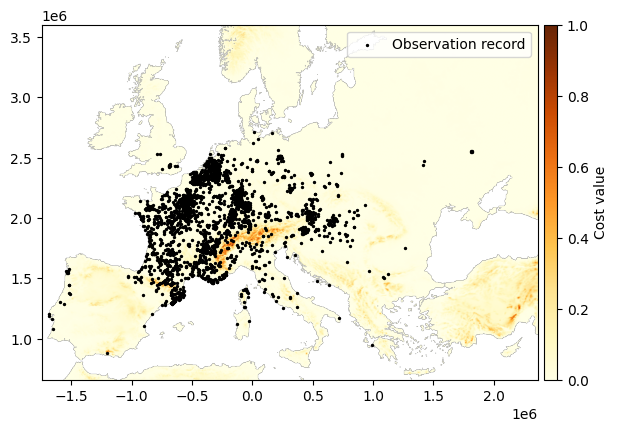

In [6]:
# VISUAL CHECK OF INPUT DATA

# Read raster data
extent = [in_cost.bounds.left, in_cost.bounds.right, in_cost.bounds.bottom, in_cost.bounds.top]
cost_arr = in_cost.read(1, masked=True)

# Read coordinates of observation data
x_coords = presence_thinned.geometry.x
y_coords = presence_thinned.geometry.y

# Initialize plot
fig, ax = plt.subplots()

# Plot the raster
cost_lyr = ax.imshow(
    cost_arr,
    extent=extent,
    cmap="YlOrBr"
)

# Define layer (axes) for the colorbar so that we can scale it to match the map height
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

# Add color bar
plt.colorbar(cost_lyr, cax=cax, label="Cost value")

# Plot the observation data
ax.scatter(
    x_coords,
    y_coords,
    facecolor="black",
    s=2,
    label="Observation record"
)

ax.legend()

# Show the plot
plt.show()

In [7]:
# CALCULATE LEAST-COST PATHS

paths = paths(out_gpkg, out_lyr_paths, presence_thinned, in_cost, year_field, start_year, end_year)

[23:13:23] Calculating least-cost paths for year 1994...
[23:13:23] Calculating least-cost paths for year 1995...
[23:13:23] Calculating least-cost paths for year 1996...
[23:13:23] INFO: No path found for a point.
[23:13:23] Calculating least-cost paths for year 1997...
[23:13:24] Calculating least-cost paths for year 1998...
[23:13:24] Calculating least-cost paths for year 1999...
[23:13:24] Calculating least-cost paths for year 2000...
[23:13:24] Calculating least-cost paths for year 2001...
[23:13:24] Calculating least-cost paths for year 2002...
[23:13:24] Calculating least-cost paths for year 2003...
[23:13:24] Calculating least-cost paths for year 2004...
[23:13:24] Calculating least-cost paths for year 2005...
[23:13:24] Calculating least-cost paths for year 2006...
[23:13:24] Calculating least-cost paths for year 2007...
[23:13:24] Calculating least-cost paths for year 2008...
[23:13:24] Calculating least-cost paths for year 2009...
[23:13:24] Calculating least-cost paths for 

In [8]:
# USER INPUT (ACCUMULATED COST THRESHOLD FOR POPULATION DELINEATION)
# Check the suggested threshold in the form and click "Submit" to save the settings.

outlier_quantile, outlier_fence = upper_outlier_fence(out_gpkg, out_lyr_paths)
w.threshold_widget(outlier_quantile)

[23:13:31] Upper outlier fence (Q3 + 1.5 x IQR) for accumulated cost is 0.047 (Q0.856).


In [9]:
# POPULATION DELINEATION
params = w.get_params()
threshold = params['threshold']

paths_grouped = group_paths(out_gpkg, out_lyr_paths, out_lyr_paths_grouped, threshold)
points_grouped = group_points(out_gpkg, out_lyr_points, out_lyr_paths_grouped, out_lyr_points_grouped, cell_size)

[23:13:44] Least-cost paths with accumulated cost < 0.067 (Q0.89) loaded.
[23:13:44] Grouping least-cost paths by their connectivity...
[23:13:46] Grouped least-cost paths saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo.gpkg', layer 'demo_paths_grouped'.
[23:13:46] Assigning observations to the groups formed by least-cost paths...
[23:13:47] Grouped observations saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo.gpkg', layer 'demo_points_grouped'.


C:\Users\Christa\AppData\Local\Temp\ipykernel_5440\1294362305.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.groupby("year").size().median())


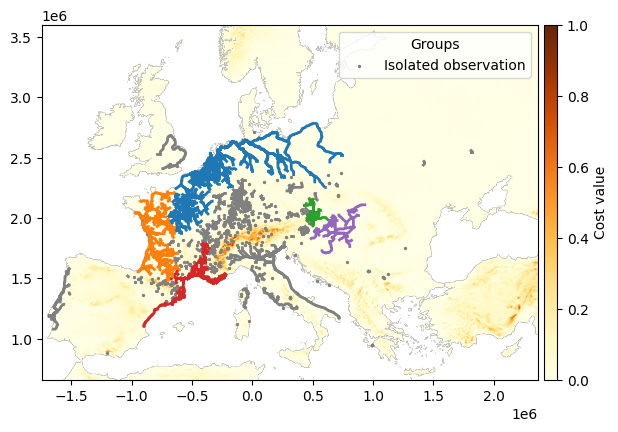

In [15]:
# VISUAL CHECK OF POPULATIONS

# Ensure group_id in paths_grouped is a string
paths_grouped["group_id"] = paths_grouped["group_id"].astype(str)

# Filter points_grouped to include only rows where group_id is null
points_isolated = points_grouped[points_grouped["group_id"].isnull()]

# Step 1: Calculate median observation count per year for each group
median_points_per_group = (
    points_grouped.groupby("group_id", group_keys=False)
    .apply(lambda df: df.groupby("year").size().median())
    .reset_index(name="median_points_per_year")
)

# Step 2: Identify the top 5 groups
top_5_groups = median_points_per_group.nlargest(5, "median_points_per_year")["group_id"].tolist()

# Step 3: Assign colors for top 5 groups and grey for others
colors = plt.cm.tab10.colors  # Categorical colormap
group_colors = {group: colors[i % len(colors)] for i, group in enumerate(top_5_groups)}
default_color = "grey"

# Initialize plot
fig, ax = plt.subplots()

# Plot the raster
cost_lyr = ax.imshow(cost_arr, extent=extent, cmap="YlOrBr")

# Add color bar with proper scaling
cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0, 0.02, ax.get_position().height])
plt.colorbar(cost_lyr, cax=cax, label="Cost value")

# Plot isolated observations
ax.scatter(
    points_isolated.geometry.x,
    points_isolated.geometry.y,
    color="grey",
    s=2,
    label="Isolated observation"
)

# Plot least-cost paths
for _, row in paths_grouped.iterrows():
    path_color = group_colors.get(row["group_id"], default_color)
    if row.geometry.geom_type == "MultiLineString":
        for line in row.geometry.geoms:
            ax.plot(*line.xy, color=path_color, linewidth=2)
    elif row.geometry.geom_type == "LineString":
        ax.plot(*row.geometry.xy, color=path_color, linewidth=2)

# Add legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = {label: handle for handle, label in zip(handles, labels)}
ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper right", title="Groups")

# Show the plot
plt.show()

In [16]:
# CALCULATE EXPANSION RATES

cum_distances, exp_rates = expansion_rate(out_gpkg, out_lyr_points_grouped, out_csv_rates, out_csv_cumdist, year_field)

[23:26:16] Calculating expansion rates for groups (populations)...


C:\Users\Christa\Documents\Git\bioinvasionanalysis\src\expansionrate.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'expansion_rate': model.params[1],  # Slope of the regression line
C:\Users\Christa\Documents\Git\bioinvasionanalysis\src\expansionrate.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'expansion_rate': model.params[1],  # Slope of the regression line
C:\Users\Christa\Documents\Git\bioinvasionanalysis\src\expansionrate.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

[23:26:17] Raw data saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo_cumulative_distances.csv'.
[23:26:17] Expansion rates saved to 'C:\Users\Christa\Documents\Git\bioinvasionanalysis\data\demo_expansion_rates.csv'.


C:\Users\Christa\Documents\Git\bioinvasionanalysis\src\expansionrate.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'expansion_rate': model.params[1],  # Slope of the regression line
C:\Users\Christa\Documents\Git\bioinvasionanalysis\src\expansionrate.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'expansion_rate': model.params[1],  # Slope of the regression line
C:\Users\Christa\Documents\Git\bioinvasionanalysis\src\expansionrate.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [ ]:
# PLOT CUMULATIVE DISTANCES AND EXPANSION RATES

#tbd